# Data Cleaning and EDA

In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', -1)

ModuleNotFoundError: No module named 'wordcloud'

In [7]:
! pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/envs/learn-env/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/wb/ttw_y56d5njf1jjf40nd748m0000gn/T/pip-install-ll8ett7f/wordcloud/setup.py'"'"'; __file__='"'"'/private/var/folders/wb/ttw_y56d5njf1jjf40nd748m0000gn/T/pip-install-ll8ett7f/wordcloud/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/wb/ttw_y56d5njf1jjf40nd748m0000gn/T/pip-wheel-xzfzlckq
       cwd: /private/var/folders/wb/ttw_y56d5njf1jjf40nd748m0000gn/T/pip-install-ll8ett7f/wordcloud/
  Complete output (65 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  creating build/lib.macosx-10.9-x86_64-3.8/wordcloud
  copying word

Failed to build wordcloud
    Running setup.py install for wordcloud ... error
    ERROR: Command errored out with exit status 1:
     command: /opt/anaconda3/envs/learn-env/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/wb/ttw_y56d5njf1jjf40nd748m0000gn/T/pip-install-ll8ett7f/wordcloud/setup.py'"'"'; __file__='"'"'/private/var/folders/wb/ttw_y56d5njf1jjf40nd748m0000gn/T/pip-install-ll8ett7f/wordcloud/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/wb/ttw_y56d5njf1jjf40nd748m0000gn/T/pip-record-uatos1wq/install-record.txt --single-version-externally-managed --compile --install-headers /opt/anaconda3/envs/learn-env/include/python3.8/wordcloud
         cwd: /private/var/folders/wb/ttw_y56d5njf1jjf40nd748m0000gn/T/pip-install-ll8ett7f/wordcloud/
    Complete output (65 lines):
  

In [2]:
df = pd.read_csv('data/data.csv', encoding = 'unicode_escape')

In [3]:
df.rename(columns={'tweet_text':'Tweet','emotion_in_tweet_is_directed_at':'Product',
                   'is_there_an_emotion_directed_at_a_brand_or_product':'Sentiment'}, inplace=True)

In [6]:
df.dropna(subset=['Tweet'],inplace=True)
df.drop_duplicates(inplace=True)
df['Product'].fillna('Unknown',inplace=True)

In [21]:
sentiment_list=[]
for i in df['Sentiment']:
    if (i=="No emotion toward brand or product")|(i=="I can't tell"):
        sentiment_list.append('Neutral')
    elif i=='Positive emotion':
        sentiment_list.append('Positive')
    elif i=='Negative emotion':
        sentiment_list.append('Negative')
df['Sentiment']=sentiment_list

In [22]:
df['Sentiment'].value_counts()

Neutral     5531
Positive    2970
Negative     569
Name: Sentiment, dtype: int64

In [9]:
df['Product'].value_counts()

Unknown                            5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: Product, dtype: int64

In [32]:
google_values = 'google','android'
apple_values = 'apple','iphone','ipad'
def brand_classification(Product, Tweet):
    brand='Unknown'
    if (Product.lower().__contains__('google'))|(Product.lower().__contains__('android')):
        brand = 'Google'
    elif (Product.lower().__contains__('apple'))|(Product.lower().__contains__('iphone'))|(Product.lower().__contains__('ipad')):
        brand = 'Apple'
    if (brand == 'Unknown'):
        lowercase_tweet = Tweet.lower()
        google = (lowercase_tweet.__contains__('google'))|(lowercase_tweet.__contains__('android'))
        apple = (lowercase_tweet.__contains__('iphone'))|(lowercase_tweet.__contains__('ipad'))|(lowercase_tweet.__contains__('apple'))
        if (google & apple):
            brand = 'Both'
        elif apple:
            brand = 'Apple'
        elif google:
            brand = 'Google'
    return brand
                
df['Brand'] = df.apply(lambda row: brand_classification(row['Product'], row['Tweet']), axis=1)
df['Brand'].value_counts()

Apple      5341
Google     2789
Unknown     759
Both        181
Name: Brand, dtype: int64

In [33]:
df.head()


,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9070 non-null   object
 1   Product    9070 non-null   object
 2   Sentiment  9070 non-null   object
 3   Brand      9070 non-null   object
dtypes: object(4)
memory usage: 674.3+ KB


In [2]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Standardize case (lowercase the text)
    # your code here
    text = text.lower()
    
    # Tokenize text using `tokenizer`
    # your code here
    text_tokens = tokenizer.tokenize(text)
    
    # Remove stopwords using `stopwords_list`
    # your code here
    text_tokens_stopped = [word for word in text_tokens if word not in stopwords_list]
    
    # Stem the tokenized text using `stemmer`
    # your code here
    final_text = [stemmer.stem(token) for token in text_tokens_stopped]
    
    # Return the preprocessed text
    # your code here
    return final_text
    
preprocess_text("This is an example sentence for preprocessing.", tokenizer, stopwords_list, stemmer)

NameError: name 'tokenizer' is not defined

In [1]:
def tweet_cleaner(tweet):
    twtr_stopwords = ['rt','rts','retweet','quot','sxsw', 'amp']
    punctuation = set(string.punctuation)
    punctuation.remove('#')
    
    x=tweet
    x=re.sub(r'https?:\/\/\S+', '', x) #remove URLs
    x=re.sub(r'{link}', '', x) #placeholders
    x=re.sub(r'@[\w]*', '', x) #@mention users
    x=re.sub('[^A-Za-z0-9]+', ' ', x) #@mention users
    x=re.sub(r'\b[0-9]+\b', '', x) #remove stand-alone numbers
    x=re.sub(r'&[a-z]+;', '', x) #remove HTML ref chars
    x=re.sub(r'\d+', '', x) #removes all NUMERALS
    x=''.join(ch for ch in x if ch not in punctuation) #remove punctuation
    x=x.replace("[^a-zA-z]", " ") #remove special chars
    
    x=[word.lower() for word in x.split() if word.lower() not in twtr_stopwords]
    x=[w for w in x if len(w)>2]
    
    return ' '.join(x)
    

In [177]:
# first_tweet = df['Tweet'][1]
# print(first_tweet)
# tweet_cleaner(first_tweet)

In [178]:
df['Cleaned_Tweet'] = df['Tweet'].map(lambda x: tweet_cleaner(x))

In [179]:
df['Cleaned_Tweet']

0       have iphone after hrs tweeting rise austin was dead need upgrade plugin stations                                             
1       know about awesome ipad iphone app that you likely appreciate for its design also they giving free                           
2       can not wait for ipad also they should sale them down                                                                        
3       hope this year festival isn crashy this year iphone app                                                                      
4       great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress                              
                                                     ...                                                                             
9088    ipad everywhere                                                                                                              
9089    wave buzz interrupt your regularly scheduled geek prog

In [180]:
df.head()

,Tweet,Product,Sentiment,Brand,Cleaned_Tweet,Preprocessed_Text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,have iphone after hrs tweeting rise austin was dead need upgrade plugin stations,"[iphon, hr, tweet, rise, austin, dead, need, upgrad, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipad iphone app that you likely appreciate for its design also they giving free,"[know, awesom, ipad, iphon, app, like, appreci, design, also, give, free]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for ipad also they should sale them down,"[wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,hope this year festival isn crashy this year iphone app,"[hope, year, festiv, crashi, year, iphon, app]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress,"[great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]"


In [181]:
stopwords_list = stopwords.words('english')
pattern = r"(?u)\w{3,}"
tokenizer = RegexpTokenizer(pattern)
stemmer = PorterStemmer()

In [182]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    text_tokens = tokenizer.tokenize(text)

    text_tokens_stopped = [word for word in text_tokens if word not in stopwords_list]
    
    final_text = [stemmer.stem(token) for token in text_tokens_stopped]
    
    return final_text

In [183]:
text_data = df.Cleaned_Tweet.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

In [184]:
df["Preprocessed_Text"] = text_data
df.head()

,Tweet,Product,Sentiment,Brand,Cleaned_Tweet,Preprocessed_Text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,have iphone after hrs tweeting rise austin was dead need upgrade plugin stations,"[iphon, hr, tweet, rise, austin, dead, need, upgrad, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipad iphone app that you likely appreciate for its design also they giving free,"[know, awesom, ipad, iphon, app, like, appreci, design, also, give, free]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for ipad also they should sale them down,"[wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,hope this year festival isn crashy this year iphone app,"[hope, year, festiv, crashi, year, iphon, app]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress,"[great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, matt, mullenweg, wordpress]"


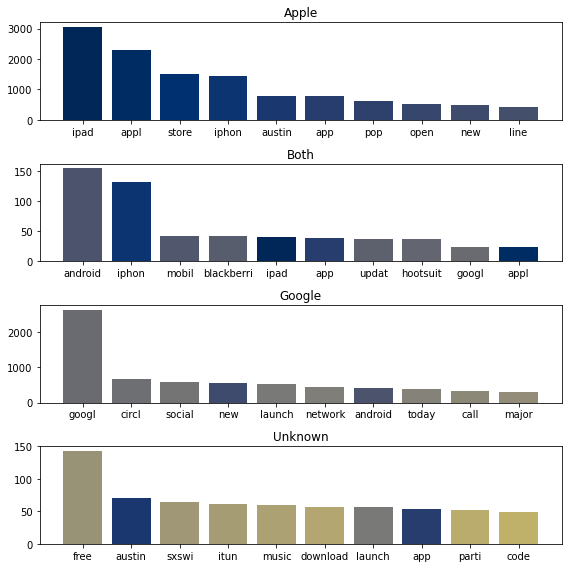

In [185]:
# Run this cell without changes
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure and axes
fig, axes = plt.subplots(nrows=4, figsize=(8, 8))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique genre
data_by_brand = [y for _, y in df.groupby('Brand', as_index=False)]
for idx, brand_df in enumerate(data_by_brand):
    # Find top 10 words in this genre
    all_words_in_genre = brand_df.Preprocessed_Text.explode()
    top_10 = all_words_in_genre.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(brand_df.iloc[0].Brand.title())
    
fig.tight_layout()

In [186]:
df.head()


,Tweet,Product,Sentiment,Brand,Cleaned_Tweet,Preprocessed_Text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,have iphone after hrs tweeting rise austin was dead need upgrade plugin stations,"[iphon, hr, tweet, rise, austin, dead, need, upgrad, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipad iphone app that you likely appreciate for its design also they giving free,"[know, awesom, ipad, iphon, app, like, appreci, design, also, give, free]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for ipad also they should sale them down,"[wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,hope this year festival isn crashy this year iphone app,"[hope, year, festiv, crashi, year, iphon, app]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress,"[great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, matt, mullenweg, wordpress]"


<Figure size 1800x1080 with 0 Axes>

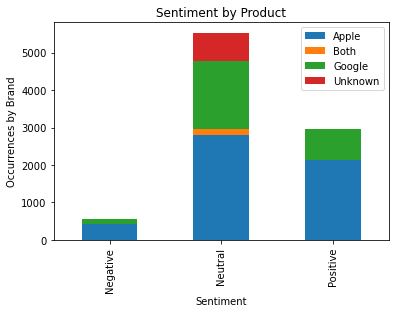

In [187]:
grouped = df.groupby(['Sentiment', 'Brand']).count()['Cleaned_Tweet']
plt.figure(figsize=(25, 15))
fig = grouped.unstack().plot(kind='bar', stacked=True, align="center")

fig.set_title('Sentiment by Product')

fig.set_xlabel('Sentiment')
fig.set_ylabel('Occurrences by Brand')
fig.legend(loc='upper right')
# plt.savefig('Images/sentiment_bars')

<Figure size 1800x1080 with 0 Axes>

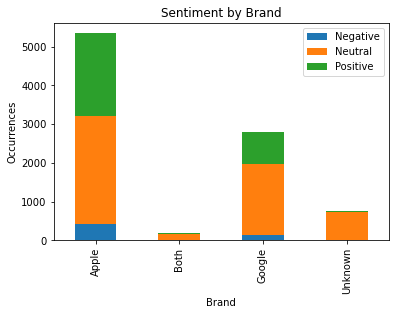

In [188]:
grouped = df.groupby(['Brand','Sentiment']).count()['Cleaned_Tweet']
plt.figure(figsize=(25, 15))
fig = grouped.unstack().plot(kind='bar', stacked=True, align="center")

fig.set_title('Sentiment by Brand')

fig.set_xlabel('Brand')
fig.set_ylabel('Occurrences')
fig.legend(loc='upper right')

In [189]:
X

0       have iphone after hrs tweeting rise austin was dead need upgrade plugin stations                                             
1       know about awesome ipad iphone app that you likely appreciate for its design also they giving free                           
2       can not wait for ipad also they should sale them down                                                                        
3       hope this year festival isn crashy this year iphone app                                                                      
4       great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress                              
                                                     ...                                                                             
9088    ipad everywhere                                                                                                              
9089    wave buzz interrupt your regularly scheduled geek prog

In [190]:
df


,Tweet,Product,Sentiment,Brand,Cleaned_Tweet,Preprocessed_Text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,have iphone after hrs tweeting rise austin was dead need upgrade plugin stations,"[iphon, hr, tweet, rise, austin, dead, need, upgrad, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipad iphone app that you likely appreciate for its design also they giving free,"[know, awesom, ipad, iphon, app, like, appreci, design, also, give, free]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for ipad also they should sale them down,"[wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,hope this year festival isn crashy this year iphone app,"[hope, year, festiv, crashi, year, iphon, app]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress,"[great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, matt, mullenweg, wordpress]"
...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive,Apple,ipad everywhere,"[ipad, everywher]"
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",Unknown,Neutral,Google,wave buzz interrupt your regularly scheduled geek programming with big news google circles,"[wave, buzz, interrupt, regularli, schedul, geek, program, big, news, googl, circl]"
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",Unknown,Neutral,Google,google zeiger physician never reported potential yet fda relies physicians operating out data healthdev,"[googl, zeiger, physician, never, report, potenti, yet, fda, reli, physician, oper, data, healthdev]"
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,Unknown,Neutral,Apple,some verizon iphone customers complained their time fell back hour this weekend course they were the new yorkers who attended,"[verizon, iphon, custom, complain, time, fell, back, hour, weekend, cours, new, yorker, attend]"


In [191]:
X = df['Cleaned_Tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [192]:
# vectorizer = CountVectorizer()
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_test_vectorized = vectorizer.transform(X_test)

In [193]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=10)
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

In [200]:
df.columns

Index(['Tweet', 'Product', 'Sentiment', 'Brand', 'Cleaned_Tweet',
       'Preprocessed_Text'],
      dtype='object')

In [211]:
# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,apple,austin,circles,google,ipad,iphone,new,social,store
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
1,0.0,0.490868,0.661806,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.566623
2,0.0,0.450123,0.606874,0.000000,0.000000,0.398897,0.0,0.00000,0.000000,0.519591
3,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.00000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.565044,0.355615,0.000000,0.0,0.48663,0.563431,0.000000
...,...,...,...,...,...,...,...,...,...,...
6797,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,1.000000
6798,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.00000,0.000000,0.000000
6799,0.0,0.654774,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.755825
6800,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000


# Modeling

### Baseline

In [215]:
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized, y_train)
baseline_model.score(X_train_vectorized, y_train)

0.6084975007350779

### RandomForest

In [219]:
rf = RandomForestClassifier()
rf.fit(X_train_vectorized, y_train)
rf.score(X_train_vectorized, y_train)

0.6281975889444281

### DecisionTree

In [216]:
dt = DecisionTreeClassifier()
dt.fit(X_train_vectorized, y_train)
dt.score(X_train_vectorized, y_train)

0.6281975889444281

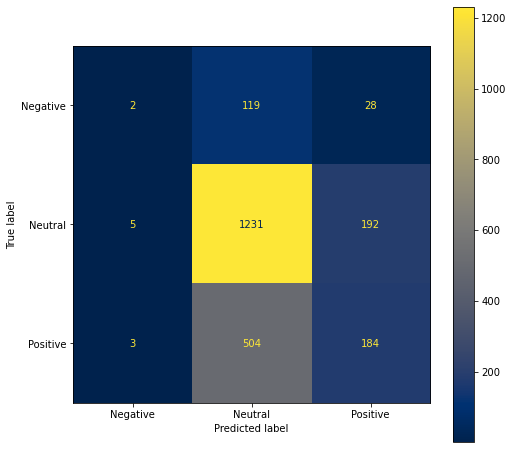

In [218]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(dt, X_test_vectorized, y_test, ax=ax, cmap="cividis");

### XGBoost

In [229]:
from xgboost import XGBClassifier

In [231]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train_vectorized, y_train)
xgb.score(X_train_vectorized, y_train)

0.6279035577771244